In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import os
import time
%matplotlib inline

### Data ETL and Data Exploration

In [6]:
import os
# os.listdir('../../dbfs/FileStore')

movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
links = pd.read_csv('links.csv')
tags = pd.read_csv('tags.csv')

In [7]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [10]:
print 'Distinct values of ratings:'
print sorted(ratings.rating.unique())

Distinct values of ratings:
[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


In [11]:
print 'For the users that rated movies and the movies that were rated:'
print 'Minimum number of ratings per user is', ratings.userId.value_counts().min()
print 'Minimum number of ratings per movie is', ratings.movieId.value_counts().min()

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1


In [12]:
print '{} out of {} movies are rated by only one user'.format(sum(ratings.movieId.value_counts() == 1), \
                                                              len(ratings.movieId.unique()))

3446 out of 9724 movies are rated by only one user


In [13]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [14]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


### Q1: The number of Users

In [16]:
num_users = np.union1d(ratings['userId'], tags['userId']).shape[0]
num_users

610L

### Q2: The number of Movies

In [17]:
np.union1d(ratings['movieId'], tags['movieId']).shape[0]

9742L

### Q3: How many movies are rated by users? List movies not rated before

In [18]:
num_movies_rated = ratings['movieId'].unique().shape[0]
num_movies_rated

9724L

In [19]:
all_movies = np.union1d(ratings['movieId'], tags['movieId'])
rated = ratings['movieId'].unique()
not_rated = [x for x in all_movies if x not in rated]

# showing 20 examples only
pd.DataFrame(not_rated, columns = ['movieId']).head(20)


,movieId
0,1076
1,2939
2,3338
3,3456
4,4194
5,5721
6,6668
7,6849
8,7020
9,7792


### Q4: List Movie Genres

In [20]:
# showing 20 examples only
pd.DataFrame(movies['genres'].unique(), columns = ['genres']).head(20)

,genres
0,Adventure|Animation|Children|Comedy|Fantasy
1,Adventure|Children|Fantasy
2,Comedy|Romance
3,Comedy|Drama|Romance
4,Comedy
5,Action|Crime|Thriller
6,Adventure|Children
7,Action
8,Action|Adventure|Thriller
9,Comedy|Horror


### Q5: Movie for Each Category

In [21]:
# showing top 20 only
movies["genres"].value_counts().head(20) 

Drama                      1053
Comedy                      946
Comedy|Drama                435
Comedy|Romance              363
Drama|Romance               349
Documentary                 339
Comedy|Drama|Romance        276
Drama|Thriller              168
Horror                      167
Horror|Thriller             135
Crime|Drama                 134
Crime|Drama|Thriller        125
Drama|War                   114
Comedy|Crime                101
Action|Comedy                92
Thriller                     84
Children|Comedy              74
Comedy|Horror                69
Action|Crime|Thriller        66
Action|Adventure|Sci-Fi      66
Name: genres, dtype: int64

### Prepare Data for Training

In [22]:
rating_data = ratings.drop(['timestamp'], axis = 1)

In [23]:
rating_data.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


## We will use a num_users x num_movies_rated matrix to represent the ratings, in which zeros are the user-movie pairs without a rating.

In [24]:
ratings_matrix = np.zeros((num_users, num_movies_rated))

usersId = np.sort(ratings.userId.unique())
moviesId = np.sort(ratings.movieId.unique())

for i in range(len(rating_data)):
    user = rating_data.iloc[i, 0]
    movie = rating_data.iloc[i, 1]
    ratings_matrix[usersId == user, moviesId == movie] = rating_data.iloc[i, 2]
    
ratings_matrix

array([[4. , 0. , 4. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2.5, 2. , 2. , ..., 0. , 0. , 0. ],
       [3. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [29]:
ratings_matrix.shape

(610L, 9724L)

## Now we split the data into training/validation/testing sets using a 6/2/2 ratio. We use a for loop to split the existing ratings for each user. Because the minimum number of ratings per user is 20, each user will have at least 12, 4, and 4 ratings in the training, validation, and testing sets, respectively.

In [25]:
import random
random.seed(0)

def data_split(ratings, ratio):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in xrange(ratings.shape[0]):
        index = ratings[user, :].nonzero()[0]
        k = int(round(len(index) * ratio))
        test_ratings = random.sample(index, k)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    return train, test


In [26]:
train_matrix, tmp = data_split(ratings_matrix, 0.4)
validation_matrix, test_matrix = data_split(tmp, 0.5)

In [27]:
print 'Number of ratings in the training set:', (train_matrix > 0).sum()
print 'Number of ratings in the validation set:', (validation_matrix > 0).sum()
print 'Number of ratings in the testing set:', (test_matrix > 0).sum()


Number of ratings in the training set: 60521
Number of ratings in the validation set: 20031
Number of ratings in the testing set: 20284


In [36]:
train_matrix.shape
validation_matrix.shape
test_matrix.shape

(610L, 9724L)

### ALS Model
Now we’ll build a ALS model. The implementation below is borrowed and modified from here. One main modification is that we train the model with the mean subtracted ratings here. At the prediction step, the mean rating will be added back. This approach makes it easier for the model to converge.



In [58]:
from numpy.linalg import solve

class ALS(object):
    
    def __init__(self, ratings, n_factors=10, reg=0.0, verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        
        reg : (float)
            Regularization term for both user and item latent factors
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        # we will train the model with the mean subtracted ratings, and 
        # at the prediction step, the mean will be added back. 
        self.raw_ratings = ratings
        self.mean = ratings[ratings > 0].mean()
        self.ratings = ratings.copy() 
        self.ratings[ratings > 0] = self.ratings[ratings > 0] - self.mean
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.reg = reg
        self._v = verbose

    def als_step(self, latent_vectors, fixed_vecs, ratings, _lambda, type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute for the item latent vectors
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in xrange(latent_vectors.shape[0]):
                #latent_vectors[u, :] = (solve((YTY + lambdaI).T, (ratings[u, :].dot(fixed_vecs)).T)).T
                latent_vectors[u, :] = solve((YTY + lambdaI), ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # input your code here to get the Y matrix
            # think about the function 2 
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in xrange(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
            
    
        return latent_vectors

    def train(self, n_iter=10):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors using a normal distribution centered at 0
        self.user_vecs = np.random.normal(0,1,(self.n_users, self.n_factors)) 
        self.item_vecs = np.random.normal(0,1,(self.n_items, self.n_factors)) 
       
        self.partial_train(n_iter)
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        count = 1
        while count <= n_iter:
            if count % 10 == 0 and self._v:
                print '\tcurrent iteration: {}'.format(count)
            self.user_vecs = self.als_step(self.user_vecs, 
                                           self.item_vecs, 
                                           self.ratings, 
                                           self.reg, 
                                           type='user')
            self.item_vecs = self.als_step(self.item_vecs, 
                                           self.user_vecs, 
                                           self.ratings, 
                                           self.reg, 
                                           type='item')
            count += 1
    
    def predict_all(self):
        """ Predict ratings for every user and item. """
        predictions = self.user_vecs.dot(self.item_vecs.T) + self.mean        
        return predictions
    
    def calculate_learning_curve(self, iter_array, valid):
        """
        Keep track of RMSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        valid : (2D ndarray)
            Validation dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_rmse : (list)
            Training data RMSE values for each value of iter_array
        valid_rmse : (list)
            Validation data RMSE values for each value of iter_array
        """
        self.iter_array = iter_array
        self.iter_array.sort()
        self.train_rmse =[]
        self.valid_rmse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(self.iter_array):
            if self._v:
                print 'Iteration: {}'.format(n_iter)
            if i == 0:
                self.train(n_iter - iter_diff)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_rmse += [get_rmse(predictions, self.raw_ratings)]
            self.valid_rmse += [get_rmse(predictions, valid)]
            if self._v:
                print 'Train RMSE: ' + str(self.train_rmse[-1])
                print 'Validation RMSE: ' + str(self.valid_rmse[-1])
            iter_diff = n_iter

    def plot_learning_curve(self):
        """ Plot the learning curves """
        plt.plot(self.iter_array, self.train_rmse, label='Training', linewidth=5)
        plt.plot(self.iter_array, self.valid_rmse, label='Validation', linewidth=5)
        plt.xticks(range(0, max(self.iter_array) + 1, 2), fontsize=16)
        plt.yticks(fontsize=16)
        plt.xlabel('iterations', fontsize=30)
        plt.ylabel('RMSE', fontsize=30)
        plt.legend(loc='best', fontsize=20) 
        plt.show()

        
def get_rmse(predictions, ratings):
    """ Calculate RMSE for predicted ratings"""
    diff = (predictions - ratings)[ratings > 0]
    return np.sqrt((diff**2).mean())

### Model Selection and Evaluation
With the ALS model, we can use a grid search to find the optimal hyperparameters.

In [59]:
latent_factors = [6, 8, 10, 12, 14]
regularizations = [0.05, 0.1, 0.2, 0.4, 0.8]

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['valid_rmse'] = np.inf
best_params['model'] = None

start_time = time.time()


for fact in latent_factors:
    for reg in regularizations:
       # put your code here to get the best model
        model =  ALS(ratings= ratings_matrix, n_factors=fact, reg=reg, verbose=True)
        model.train()
        predictions = model.predict_all()
        acc = get_rmse(predictions, validation_matrix)
        if acc < best_params['valid_rmse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['valid_rmse'] = acc
            best_params['model'] = ALS(ratings= train_matrix, n_factors=fact, reg=reg, verbose=True)
            
#             print("predictions:",predictions)
#             print("acc:",acc)
# ratings_matrix
#         train_matrix
#         validation_matrix
#         test_matrix


print '\nThe best model has {} latent factors and regularization = {}'.format(\
        best_params['n_factors'], best_params['reg'])        
print 'Total Runtime: {:.2f} seconds'.format(time.time() - start_time)

	current iteration: 10
	current iteration: 10
	current iteration: 10
	current iteration: 10
	current iteration: 10
	current iteration: 10
	current iteration: 10
	current iteration: 10
	current iteration: 10
	current iteration: 10
	current iteration: 10
	current iteration: 10
	current iteration: 10
	current iteration: 10
	current iteration: 10
	current iteration: 10
	current iteration: 10
	current iteration: 10
	current iteration: 10
	current iteration: 10
	current iteration: 10
	current iteration: 10
	current iteration: 10
	current iteration: 10
	current iteration: 10

The best model has 14 latent factors and regularization = 0.8
Total Runtime: 173.46 seconds


In [60]:
# ##### test 
# model =  ALS(ratings= ratings_matrix, n_factors= 8, reg=0.5, verbose=True)
# model.calculate_learning_curve( [1, 2, 5, 10], validation_matrix)

Iteration: 1
Train RMSE: 1.0423459263074697
Validation RMSE: 1.0440286003182992
Iteration: 2
Train RMSE: 0.902838416002783
Validation RMSE: 0.9075295721032829
Iteration: 5
Train RMSE: 0.8947689489223751
Validation RMSE: 0.900052485959601
Iteration: 10
Train RMSE: 0.8935171943634741
Validation RMSE: 0.8986365771500032


In [62]:
# ############# test
# acc = get_rmse(train_matrix, validation_matrix)
# acc

3.6492613611322944

The model with 10 latent factors and lambda = 0.4 yields the best result. Let's plot the learning curves for this model.

In [63]:
best_model = best_params['model']
iter_array = [1, 2, 5, 10]

In [64]:
best_model.calculate_learning_curve(iter_array, validation_matrix)

Iteration: 1
Train RMSE: 1.0403472704977905
Validation RMSE: 1.044193950957279
Iteration: 2
Train RMSE: 0.8751608478685549
Validation RMSE: 1.0192148886279946
Iteration: 5
Train RMSE: 0.8657174320217657
Validation RMSE: 1.0133950767477093
Iteration: 10
Train RMSE: 0.8668604767118318
Validation RMSE: 1.0121681910427551


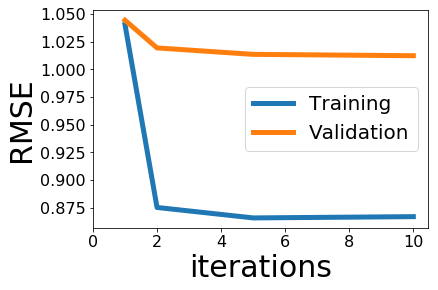

In [65]:
best_model.plot_learning_curve()

And finally, let's check the testing error.

In [66]:
print 'For testing data the RMSE is {}'.format(get_rmse(best_model.predict_all(), test_matrix))


For testing data the RMSE is 1.01287699209


This is consistent with our validation error.